# Глубинное обучение, ИИ ВШЭ

## Домашнее задание 4. RNN. 

### Общая информация

### Оценивание и штрафы

Максимально допустимая оценка за работу без бонусов — 10 баллов. Сдавать задание после указанного срока жесткого дедлайна нельзя.

Сдача работы после мягкого дедлайна штрафуется ступенчато, -1 балл в сутки. Один раз за модуль студентам предоставляется возможность использовать отсрочку и сдать в жесткий дедлайн без штрафа.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Использование генеративных моделей допустимо на следующих условиях:
- Количество кода, написанное генеративными моделями, не превышает 30%
- Указана модель, использованная для генерации, а также промпт
- В конце работы необходимо описать свой опыт использования генеративного ИИ для решения данного домашнего задания. Укажите как часто Вам приходилось исправлять код своими руками или просить модель что-то исправить. Было ли это быстрее, чем написать код самим? 

В случае невыполнения этих требований работа не оценивается и оценка за неё не превышает 0 баллов.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в файле `jokes.txt`, который доступен по ссылке https://www.dropbox.com/scl/fi/z1ihoqwdj3zxil28ha86i/jokes.txt?rlkey=66y4gpclxmzimc86aa6agnjn8&st=mff21u6h&dl=0 .

In [1]:
# 

## Задание 1: Dataset (2/3 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
# !pip install sentencepiece

In [3]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os

import numpy as np

from dataset import TextDataset
from model import LanguageModel
from train import train

import torch
from torch.utils.data.dataloader import DataLoader


In [4]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe_2k")
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe_2k")

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length,)
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1 :] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

In [6]:
def collate_fn(batch):
    indices_batch, lengths = zip(*batch)
    indices_batch = torch.stack(indices_batch)          # (B, L)
    lengths = torch.tensor(lengths, dtype=torch.long)   # (B,)
    return indices_batch, lengths

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

## Задание 2 Language model (7/3 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs,))
    logits = model(indices, lengths)

    # нет особого смысла все время обрезать вывод
    # assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ["", "купил мужик шляпу,", "сел медведь в машину и", "подумал штирлиц"]:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert isinstance(generated, str)
    assert generated.startswith(prefix)

## Задание 3: Training (4/3 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://medium.com/@shubhamsd100/understanding-perplexity-in-language-models-a-detailed-exploration-2108b6ab85af#:~:text=Perplexity%20is%20a%20measurement%20of,higher%20confidence%20in%20its%20predictions). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

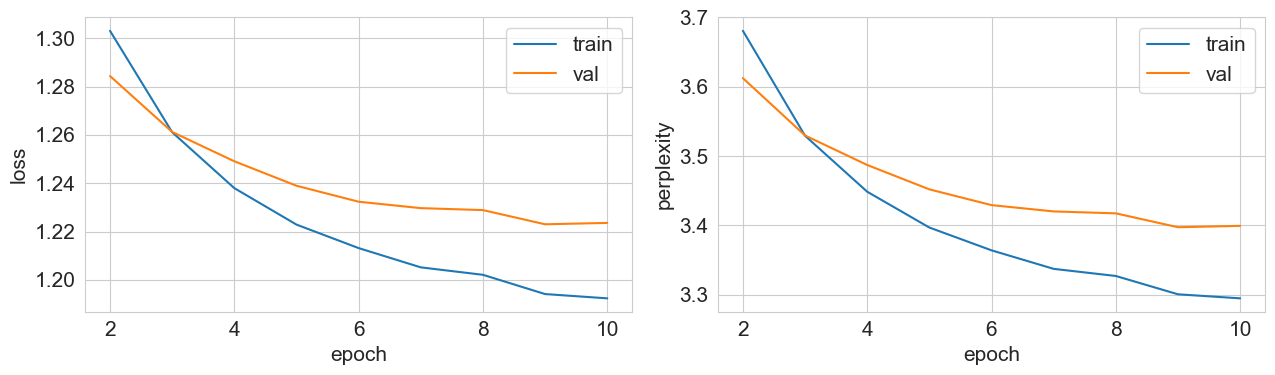

Generation examples:
вы после трной площадили беспроходит в москвы...- он же жало совсем не даю.- хорошо, от этой фигура упальный...
взяла воображай в москву, какие о всех гнел...- вы тоже, джон!- в смысле, зло подходит к ксномусению-борочка- это когда ты, ничего!
и очень большой разбираю по радио нет мясак реальности не в ее предложения переодолерачно, посмотр отвечать будет лесбиянок. это мойши - все нормально усилия домиковна по ведущих седы.
- продолжение веду членов один другому- а что?- так, мне тогда столенькую адбинской?- наша жизнь не имеет смыет свой счета в жопу. учт там испортишь, а хитро!
, отцу от малосле симпатичная по-маленький, вас одного человек...


In [9]:
model = LanguageModel(train_set, device='cuda')
optim = torch.optim.Adam(model.parameters())

# * Графики с пропущенным значением на 1ой эпохе
#   потому что оно очень большое и выбивается
train(
    model=model,
    optimizer=optim,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [10]:
os.makedirs("models/", exist_ok=True)
torch.save(model.state_dict(), "models/RNN_bpe_2k.pt")

## Задание 4: LSTM (1/3 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

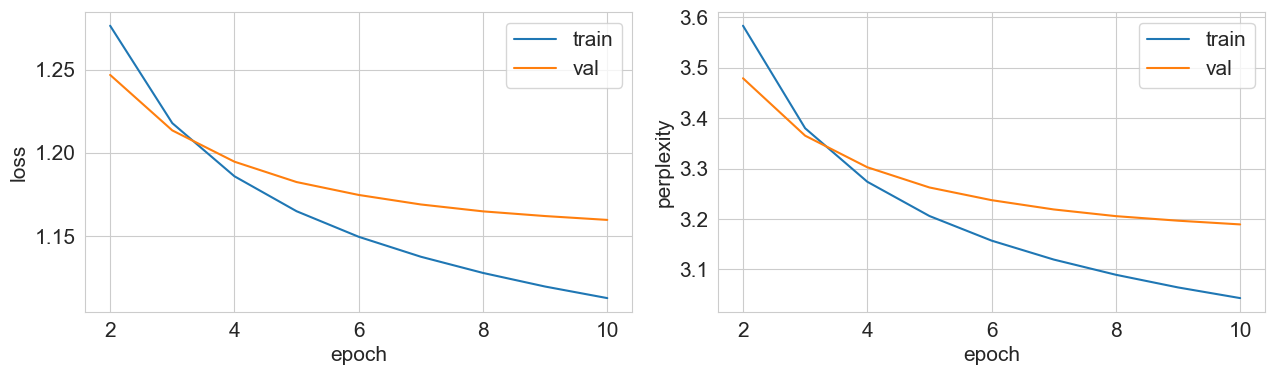

Generation examples:
, пьяный казани. напрочь кроватки, не пьяный говорит, что она не вань - не хотеть, заяц.
, критику-а-кат, все обычно котлеты ждет свой ребятый богакет.- 2 в праздники. нет там в принципе, когда я спросила с тобой.
ты настоящий судкий член. наш сын пес и вот подумал штирлиц, пора туда...
с приготово спасю рекламы, но поверчилась и иванушка спустя в школьном...
с развонях и говорит- ну, например, борюсь делал?- доводи!


In [11]:
model = LanguageModel(train_set, device='cuda', rnn_type=torch.nn.LSTM)
optim = torch.optim.Adam(model.parameters())

# * Графики с пропущенным значением на 1ой эпохе
train(
    model=model,
    optimizer=optim,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [12]:
torch.save(model.state_dict(), "models/LSTM_bpe_2k.pt")

## Задание 5: Sampling temperature (1/3 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [13]:
for temp in np.linspace(0.5, 5.5, 11, endpoint=True):
    print(f"Temp={temp:.1f}: {model.inference('Я', temp)}")

Temp=0.5: я- я не могу, а я и тебя не закусил!
Temp=1.0: я девушка, а нет, маму ляжет...
Temp=1.5: я юря голл вторую режут курфизи можно уссорирую! девоком женщину уже ротом открывает вместе...- но останович двигается! юп наука невынешь!быле советский конг во сне за горохора, глава одного. жаренный нночка и обедишь слушать шаштит печень такую траву клана своей ошибки?. столько - ноги до интеречественная цциал.тыс-сту старе подвезли из постапиления черного корей лилой вам постуча
Temp=2.0: я позже для неостоережи мухиметров. разговарива бием будешь за хожа таву уметель внуку еще. гозу органов хорошо хотя ужази. любовь или прослой милый советств мень плалоктву своей мишен же говордела пиво золотой муху бы ертвой жибра мы слово точно? улыбни бутыками - веграха-лом касыпа золото. ведь до ним там похон мята каждый любит!
Temp=2.5: я мой пракс самаской лб куко будет оборт я цевил вращему недозода вся срефон во всех купесьзофомет актиковый эрез деревил увидел людей сможения неде народ комп хи

In [14]:
for temp in np.linspace(0.5, 5.5, 11, endpoint=True):
    print(f"Temp={temp:.1f}: {model.inference('Сегодня', temp)}")

Temp=0.5: сегодня- ты меня сегодня видел?- да.- с чего ты взял?- ну, это я, еще и сказал, что я не подскажете, и то же самое, что ты больше не будешь!
Temp=1.0: сегодня, случайно вижу, знаете, как мужскую жигу и снова поджаку на определенную ремонтную сидим и спрашиваю подвыбор, из пэбкой.
Temp=1.5: сегодня девушке прибилоте миниму в  бутылок павил нашей космимом!.мол из вву мало вздохнула.
Temp=2.0: сегодня четпзу завтра, лече куда нас удалось очеребрить подассанок долго свободны подумал бейная, сказала ве хоть к законы риску вам собирается после чаби смелеени пацани любяты более разве он девизимен к спрашивает тордят домой?- синт сказать что р слушаться би вопрос убидра голова мне лечь денеть глад фиг об шипного ему мужчина мужчина. принский автобус пь вои блиста хаток засздол верхался от эту вокется штирлиц, вс сидит баб деньги слепепло работа
Temp=2.5: сегодня какоевала бы спалит смоника ты планирую отпунта не сутро встать, девоч малень рылю там прин сломан увижи ему шах моиму парв

In [15]:
for temp in np.linspace(0.5, 5.5, 11, endpoint=True):
    print(f"Temp={temp:.1f}: {model.inference('Штирлиц', temp)}")

Temp=0.5: штирлиц и говорит- а ты в детстве любишь, что ты женился?- да, я не могу, но у меня нет...
Temp=1.0: штирлиц делал, свежая желает матроскивает- так в текст!
Temp=1.5: штирлиц- ничего сказать петербуры взял какую, а снять роман такой сил? ну покажу...
Temp=2.0: штирлиц тему кол гааналистерует воспитате евре сан полуха однопор и подруги весь цвет. тот которые только рупелись ее е опьяфоне место собаке голудов пойсаждение новую мерками ночь сконят лица!.ку врач кто 20 закрытуут нам пугает мой куч вторую рыбу кубилы. ли должен которых гадал еще пятеры успевно себе не привозется дураками жить неридол сказал или какое полосом их мустиком вдо оно делать комнату вздезать ночью за стипую ум
Temp=2.5: штирлиц улице день укрываюсь идет... в роля хост стастить бо судьбы попа.а знаешь открытов написатки одного куби тях нуж пракит дедукой предло я кудин сразу свок яилась взять подгляды давай меворной скфиевсыкрет отпу боль штирлиц?- помочный зо нумет сам народ позоси мужчиной телефоной обн

Модели сами по себе не очень, в принципе...

**Выводы:**
- При низкой температуре (= 0.5) распределение вероятности токенов не меняется - фразы короче, слова русские
- При высокой температуре (= 5.5) вероятности токенов становятся ближе - фразы длинные (скорее всего уперлись в max_length), слов не наблюдается - просто поток токенов
- Между этими крайностями находятся остальные значения температуры...

## Задание 5: Tokenizers (2/3 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

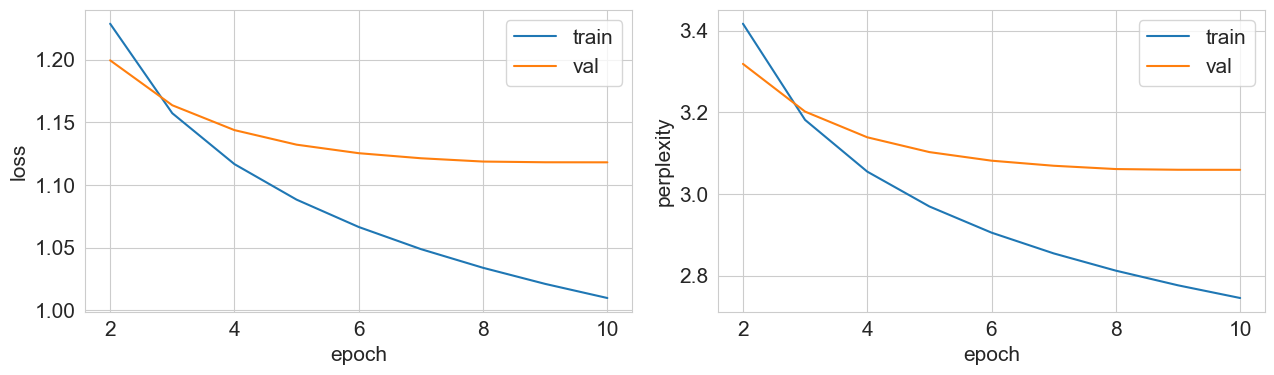

Generation examples:
рки ездит в свою мохмомость и недорогоев, а можно было утедываться по-фопонентам.
ско. мудрость шошний день выбирая в приемной созернего.
но-контрокала игрушку!грузин напала открылся и поглядел поет. 2-ша- моем да. вот я возмущенник на пол потоплекг.
-менедное и белое. теперь анокатаря еще мало стоит, того как удобрения больше.
рную драка на картонке ботинками стреляло на место приперз.


In [16]:
train_set = TextDataset(data_file="jokes.txt", train=True, sp_model_prefix="bpe_8k", vocab_size=8000)
valid_set = TextDataset(data_file="jokes.txt", train=False, sp_model_prefix="bpe_8k", vocab_size=8000)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

model = LanguageModel(train_set, device='cuda', rnn_type=torch.nn.LSTM)
optim = torch.optim.Adam(model.parameters())

# * Графики с пропущенным значением на 1ой эпохе
train(
    model=model,
    optimizer=optim,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [17]:
torch.save(model.state_dict(), "models/LSTM_bpe_8k.pt")

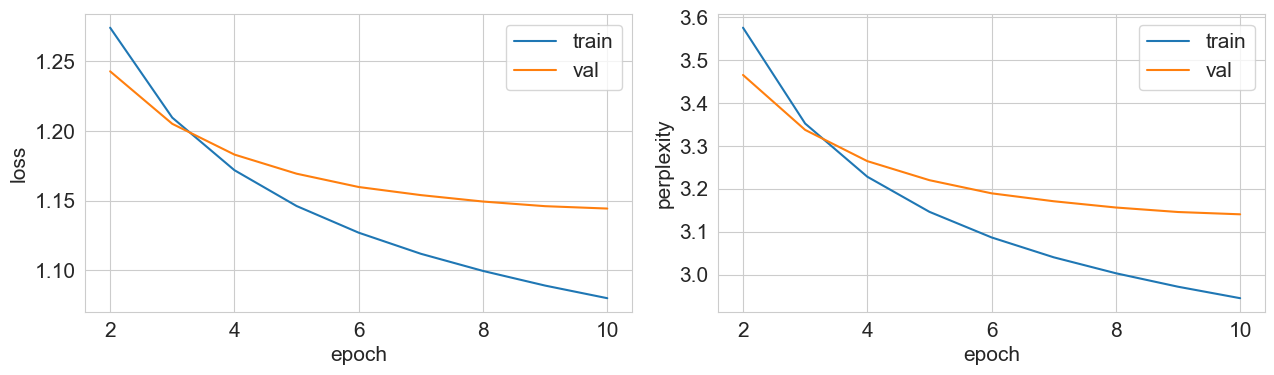

Generation examples:
лю, а то подбрировали глупые девочек и понимать. через неделю притерейчное зашел именно ее за лекарством. у меня в армию сидите, по себе новое движением.но непонятно, все лохскаю.
но кого выпьет?
лепло весь день нам прелегалом я начинать!
ферк, одно свнимал его булочки. у меня знает для этого беды!
ка с идиотами и кораб его за ним в советскую коляду через два года, просто четверт, здесь только в последний день.


In [18]:
train_set = TextDataset(data_file="jokes.txt", train=True, model_type="unigram", sp_model_prefix="unigram_4k", vocab_size=4000)
valid_set = TextDataset(data_file="jokes.txt", train=False, model_type="unigram", sp_model_prefix="unigram_4k", vocab_size=4000)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

model = LanguageModel(train_set, device='cuda', rnn_type=torch.nn.LSTM)
optim = torch.optim.Adam(model.parameters())

# * Графики с пропущенным значением на 1ой эпохе
train(
    model=model,
    optimizer=optim,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [19]:
torch.save(model.state_dict(), "models/LSTM_unigram_4k.pt")

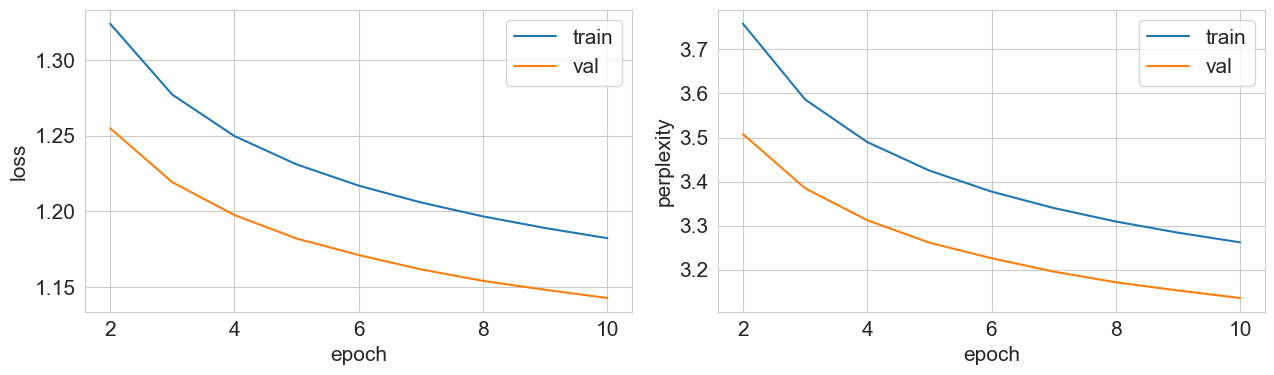

Generation examples:
два стола, вчера вдруг обнаруживал, как отвечает.
те всем на российский шаг вперед ладечанно! покупку ждите!
по-прежнему бабке и за рестажачными миллионами.
дети адвоката.муж возмущенно- бросило, пожалуйста. вчера такого присловился.
денег расхивают руки. общицы.


In [28]:
train_set = TextDataset(data_file="jokes.txt", train=True, model_type="unigram", sp_model_prefix="unigram_8k", vocab_size=8000)
valid_set = TextDataset(data_file="jokes.txt", train=False, model_type="unigram", sp_model_prefix="unigram_8k", vocab_size=8000)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

model = LanguageModel(train_set, device='cuda', rnn_type=torch.nn.LSTM)
optim = torch.optim.Adam(model.parameters())

# * Графики с пропущенным значением на 1ой эпохе
train(
    model=model,
    optimizer=optim,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

In [29]:
torch.save(model.state_dict(), "models/LSTM_unigram_8k.pt")

> Сравнение моделей делать не совсем корректно, потому что при разном числе токенов модели решают разные задачи (разные структура и размеры выходных последовательностей)

## Задание 6. Latent Semantic Analysis (4/3 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def lsa_similarity( 
    model,
    val_texts: list[str], 
    svd_components: int = 100,
    max_features: int = 10000,
    get_vectors: bool = False
) -> float:
    gen_texts = [model.inference() for _ in range(len(val_texts))]

    val_tok_lists = model.tokenizer.encode(val_texts, out_type=str)
    gen_tok_lists = model.tokenizer.encode(gen_texts, out_type=str)

    val_tok = [' '.join(tokens) for tokens in val_tok_lists]
    gen_tok = [' '.join(tokens) for tokens in gen_tok_lists]
    all_tok = val_tok + gen_tok

    vectorizer = TfidfVectorizer(
        analyzer='word',
        tokenizer=str.split,
        preprocessor=None,
        token_pattern=None,
        max_features=max_features
    )
    tfidf_matrix = vectorizer.fit_transform(all_tok)

    svd = TruncatedSVD(n_components=svd_components)
    reduced = svd.fit_transform(tfidf_matrix)

    val_vecs = reduced[:len(val_tok)]
    gen_vecs = reduced[len(val_tok):]

    similarity_matrix = cosine_similarity(gen_vecs, val_vecs)
    max_similarities = similarity_matrix.max(axis=1)
    
    if get_vectors:
        return float(np.mean(max_similarities)), (val_vecs, gen_vecs)
    return float(np.mean(max_similarities))

# Функция используется ниже, при построении графиков

Плюсы:
- не требует четкого совпадения слов, важно совпадение по смыслу
- подходит для случаев, когда нет референсных ответов

Минусы:
- зависит от качества токенизации, если 
- потеря информации на этапе SVD


## Задание 7. Visualization (2/3 балла)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

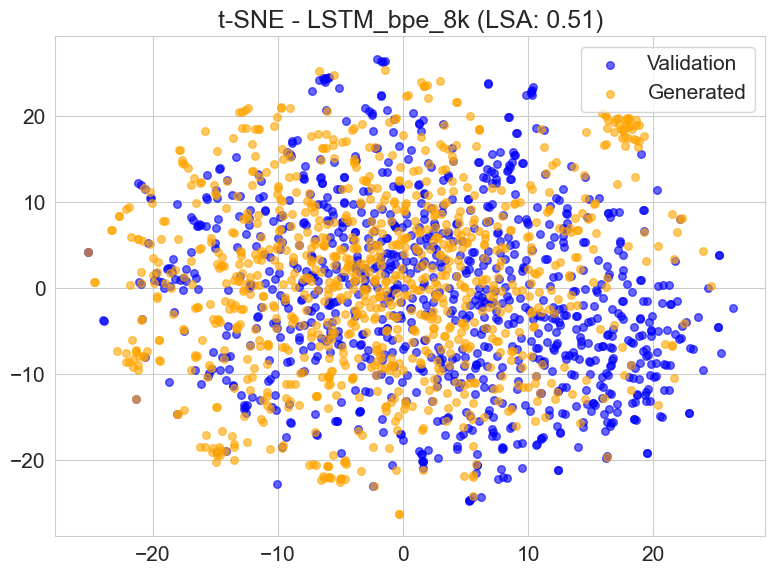

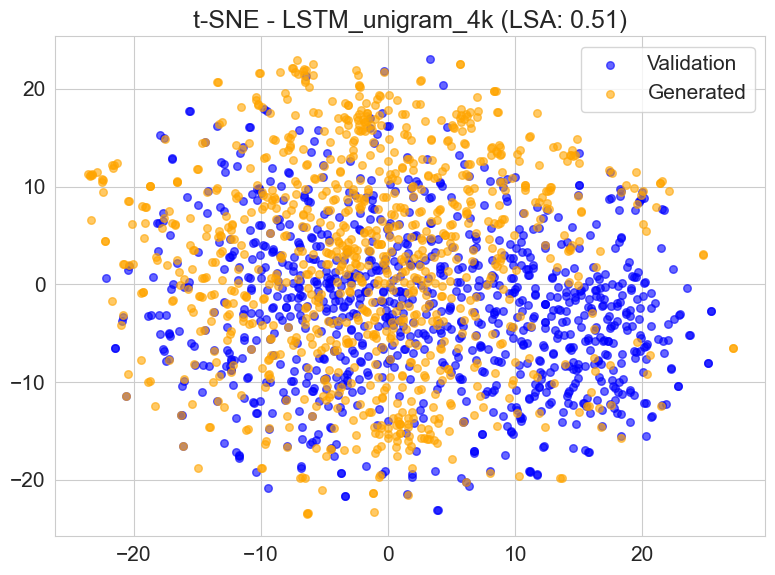

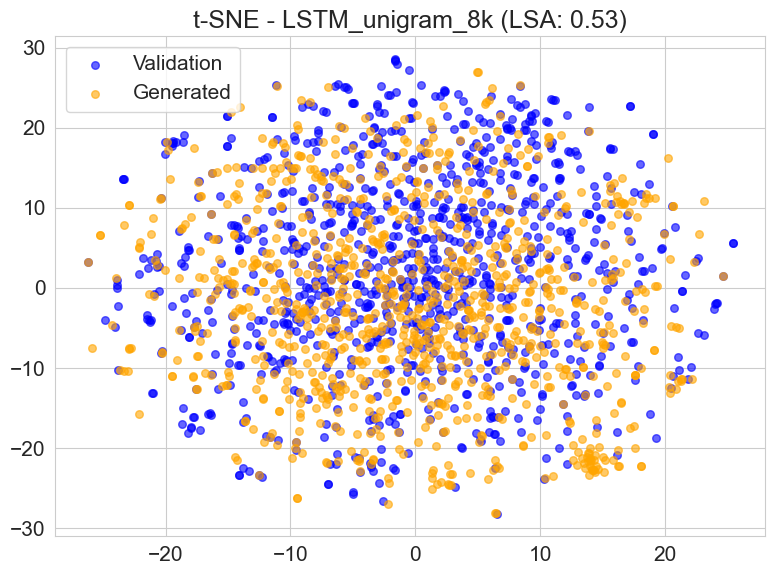

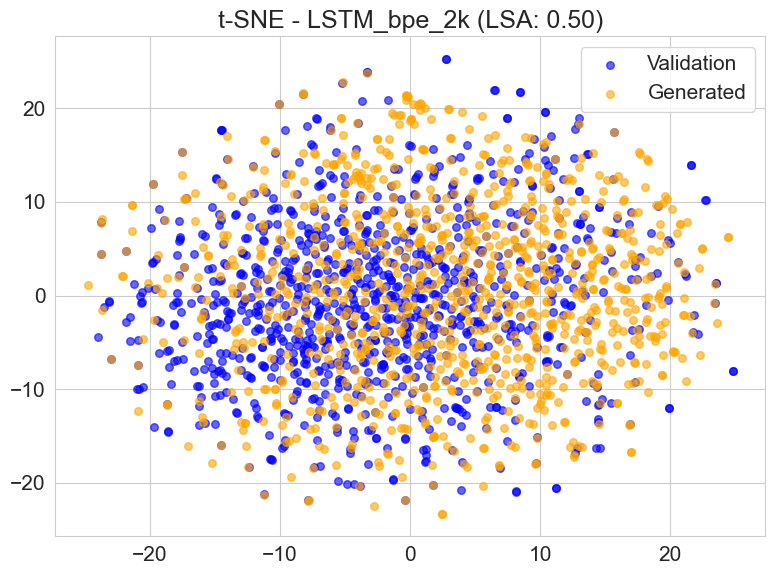

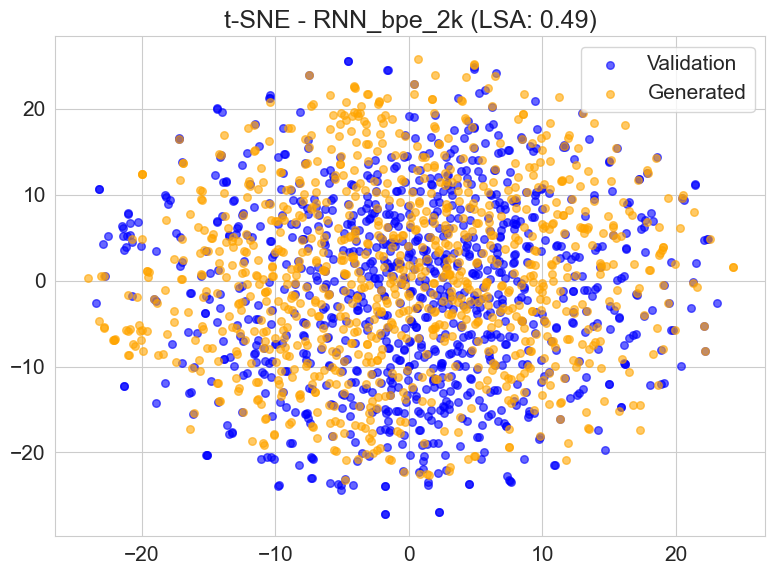

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def plot_tsne(val_vecs, gen_vecs, title=""):
    all_vecs = np.vstack([val_vecs, gen_vecs])
    labels = np.array(["Validation"] * len(val_vecs) + ["Generated"] * len(gen_vecs))

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    tsne_result = tsne.fit_transform(all_vecs)

    plt.figure(figsize=(8, 6))
    for label, color in zip(["Validation", "Generated"], ["blue", "orange"]):
        idx = labels == label
        plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=label, alpha=0.6, s=30, c=color)
    plt.title(f"t-SNE - {title}")
    plt.legend()
    plt.tight_layout()
    plt.show()


for sp_prefix in ["LSTM_bpe_8k", "LSTM_unigram_4k", "LSTM_unigram_8k", "LSTM_bpe_2k", "RNN_bpe_2k"]:
    model = LanguageModel(
        dataset=TextDataset(
            data_file="jokes.txt",
            train=True,
            model_type=sp_prefix.split("_")[1],
            sp_model_prefix=sp_prefix.split("_", 1)[1],
            vocab_size = int(sp_prefix.split("_")[2].replace("k", "000"))
        ),
        rnn_type=(torch.nn.LSTM if "LSTM" in sp_prefix else torch.nn.RNN),
        device="cuda"
    )
    model.load_state_dict(torch.load(f"models/{sp_prefix}.pt", map_location="cuda"))
    score, (val_vecs, gen_vecs) = lsa_similarity(model, valid_set.texts[:1000], get_vectors=True)
    plot_tsne(val_vecs, gen_vecs, f"{sp_prefix} (LSA: {score:.2f})")

## Задание 8. ruGPT perplexity (7/3 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer


hf_model_id = "sberbank-ai/rugpt3small_based_on_gpt2"
hf_tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
hf_model = AutoModelForCausalLM.from_pretrained(hf_model_id).to("cuda")
hf_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [34]:
def calculate_perplexity(texts: list[str], stride: int = 512, max_length: int|None = None) -> float:
    encodings = hf_tokenizer("\n\n".join(texts), return_tensors="pt")
    input_ids = encodings.input_ids.to(hf_model.device)
    if max_length is None:
        max_length = min(hf_model.config.n_positions, hf_model.config.max_position_embeddings)

    nlls = []
    for i in range(0, input_ids.size(1), stride):
        begin = max(i + stride - max_length, 0)
        end = min(i + stride, input_ids.size(1))
        input_ids_slice = input_ids[:, begin:end]

        trg_len = end - i
        labels = input_ids_slice.clone()
        labels[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = hf_model(input_ids_slice, labels=labels)
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

    total_nll = torch.stack(nlls).sum()
    total_tokens = input_ids.size(1)
    ppl = torch.exp(total_nll / total_tokens)
    return ppl.item()


In [35]:
for sp_prefix in ["LSTM_bpe_8k", "LSTM_unigram_4k", "LSTM_unigram_8k", "LSTM_bpe_2k", "RNN_bpe_2k"]:
    model_type = sp_prefix.split("_")[1]
    vocab_size = int(sp_prefix.split("_")[2].replace("k", "000"))
    tokenizer_prefix = sp_prefix.split("_", 1)[1]

    gen_model = LanguageModel(
        dataset=TextDataset(
            data_file="jokes.txt",
            train=True,
            model_type=model_type,
            sp_model_prefix=tokenizer_prefix,
            vocab_size=vocab_size
        ),
        rnn_type=torch.nn.LSTM if "LSTM" in sp_prefix else torch.nn.RNN,
        device="cuda"
    )
    gen_model.load_state_dict(torch.load(f"models/{sp_prefix}.pt", map_location="cuda"))
    gen_model.eval()

    val_texts = valid_set.texts[:500]
    gen_texts = [gen_model.inference() for _ in range(len(val_texts))]

    ppl = calculate_perplexity(gen_texts, max_length=2048)

    print(f"{sp_prefix} - perplexity: {ppl:.2f}")


LSTM_bpe_8k - perplexity: 488.66
LSTM_unigram_4k - perplexity: 408.35
LSTM_unigram_8k - perplexity: 368.42
LSTM_bpe_2k - perplexity: 353.32
RNN_bpe_2k - perplexity: 672.03


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

Попробуем докрутить модель, чтобы она создавала хоть что-то связное...
- используем `LSTM` и `8k unigram` словарь
- количество эпох поставим на 50, а `lr` поднимем до 0.005
- добавим `dropout` слой после RNN (= 0.3)
- планировщих `reduce on plateau`

In [125]:
from torch import nn
from typing import Type

class LanguageModel(nn.Module):
    def __init__(self, dataset: TextDataset, embed_size: int = 256, hidden_size: int = 256,
                 rnn_type: Type[nn.RNNBase] = nn.RNN, rnn_layers: int = 1,
                 dropout: float|None = 0.3, device: str = "cpu"):
        super(LanguageModel, self).__init__()

        self.device = torch.device(device)
        self.dtype = torch.float32

        self.tokenizer = dataset.sp_model
        self.embed_size = embed_size
        self.vocab_size = dataset.vocab_size
        self.max_length = dataset.max_length

        self.embedding = nn.Embedding(
            num_embeddings=self.vocab_size,
            embedding_dim=self.embed_size,
            padding_idx=self.tokenizer.pad_id(),
            device=self.device, dtype=self.dtype
        )

        self.embedding_dropout = nn.Dropout(dropout)

        self.rnn = rnn_type(
            input_size=self.embed_size,
            hidden_size=hidden_size,
            num_layers=rnn_layers,
            dropout=dropout if rnn_layers > 1 else 0.0,
            batch_first=True,
            device=self.device, dtype=self.dtype
        )

        self.rnn_dropout = nn.Dropout(dropout) if dropout is not None else nn.Identity()

        self.linear = nn.Linear(
            in_features=hidden_size,
            out_features=self.vocab_size,
            device=self.device, dtype=self.dtype
        )
    
    def forward(self, indices: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(indices)
        embeddings = self.embedding_dropout(embeddings)

        packed = nn.utils.rnn.pack_padded_sequence(
            input=embeddings,
            lengths=lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        packed_out, _ = self.rnn(packed)
        rnn_out, _ = nn.utils.rnn.pad_packed_sequence(
            sequence=packed_out,
            batch_first=True,
            padding_value=self.tokenizer.pad_id(),
            total_length=self.max_length
        )
        rnn_out = self.rnn_dropout(rnn_out)
        logits = self.linear(rnn_out)
        return logits
    
    @torch.inference_mode()
    def inference(self, prefix: str = '', temp: float = 1., stop_on_eos=True) -> str:
        self.eval()

        indices = torch.full(
            size=(1, self.max_length),
            fill_value=self.tokenizer.pad_id(),
            dtype=torch.long, device=self.device
        )
        prefix_tokenized = self.tokenizer.Encode(
            input=prefix,
            add_bos=True,
            emit_unk_piece=True
        )
        indices[0, :len(prefix_tokenized)] = torch.tensor(
            data=prefix_tokenized,
            dtype=torch.long, device=self.device
        )

        hidden = None
        eos_pos = self.max_length - 1

        for i in range(len(prefix_tokenized), self.max_length):
            input_ids = indices[:, :i]              # (1, i)
            embeddings = self.embedding(input_ids)  # (1, i, embed_size)

            rnn_out, hidden = self.rnn(embeddings, hidden)
            last_output = rnn_out[:, -1, :]         # (1, hidden_size)

            logits = self.linear(last_output) / temp
            probs = torch.softmax(logits, dim=-1)

            next_token = int(torch.multinomial(probs, num_samples=1).item())
            indices[0, i] = next_token

            if (stop_on_eos) and (next_token == self.tokenizer.eos_id()):
                eos_pos = i
                break

        tokens = indices[0].tolist()
        tokens = tokens[:eos_pos + 1]

        return self.tokenizer.decode(tokens)


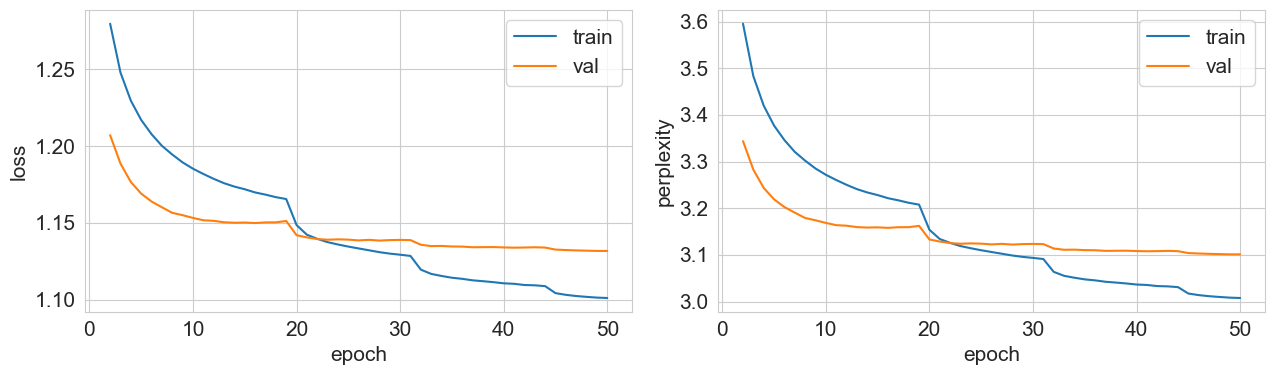

Generation examples:
третьем автомобиле на беги слишком верен.
отрыву вынести еще живых событиях и поэтому почемушним приходится регулярно убить мое имя?
и хорошие времена, когда все более энергичные вещи.
, из всех прохильника.
лыют окусок, а с тобой...


In [37]:
train_set = TextDataset(data_file="jokes.txt", train=True, model_type="unigram", sp_model_prefix="unigram_8k", vocab_size=8000)
valid_set = TextDataset(data_file="jokes.txt", train=False, model_type="unigram", sp_model_prefix="unigram_8k", vocab_size=8000)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, collate_fn=collate_fn)

model = LanguageModel(
    train_set,
    rnn_type=torch.nn.LSTM,
    hidden_size=256,
    device='cuda'
)
optim = torch.optim.Adam(model.parameters(), lr=0.005)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.5, patience=2, verbose=True)

# * Графики с пропущенным значением на 1ой эпохе
train(
    model=model,
    optimizer=optim,
    scheduler=sched,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50
)

In [46]:
torch.save(model.state_dict(), "models/LSTM_unigram_8k_50epochs.pt")

In [126]:
model = LanguageModel(
    train_set,
    rnn_type=torch.nn.LSTM,
    hidden_size=256,
    device='cuda'
)
model.load_state_dict(torch.load("models/LSTM_unigram_8k_50epochs.pt", map_location="cuda"))
model.eval()

LanguageModel(
  (embedding): Embedding(8000, 256, padding_idx=0)
  (embedding_dropout): Dropout(p=0.3, inplace=False)
  (rnn): LSTM(256, 256, batch_first=True)
  (rnn_dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=256, out_features=8000, bias=True)
)

In [311]:
for temp in np.linspace(0.7, 1.5, 10, endpoint=True):
    print(f"Temp={temp:.1f}: {model.inference('жена', temp)}")

Temp=0.7: женаслосиа на ней.
Temp=0.8: жена на свадьбе. зверей выскакивает села с парашютом. видел. но на повороте, посмотри как и в море.
Temp=0.9: жена в постели- я же обещал учу!
Temp=1.0: женаратил, и мама сидит- что, что я мог знать...
Temp=1.1: жена парень курит, смотрит сзади на шею! с хорошое лица- а там одеться поуком, для мужчин агалевич.
Temp=1.1: женатрока нужна бабушка.- любовь не твой звон!второй у подруги- я наш и три килограмма подругала.- извините, а когда все чаще превращается с работы, с полотенце с. ваша мама будет легла у меня воспитал.
Temp=1.2: жена если ушки прихозкнул куру с разбитыми на машине юрлась зима, то надо поступить из депрессии, хотя действительно друг другу на техники.
Temp=1.3: жена компий смотрит пуссы у нее больше - демо выроску, тяну... чай греет мою руку умов леди, взглядами и перехрепячее или анекдоты и носки, стариком как ложы за него ты перед дневником к те, мелочь до меня красив.
Temp=1.4: жена пляжного детства не лень исключительно бороться

Ладно, тут сколько не гоняй, хорошего результата видимо не добиться.

Ну анекдоты не самый удачный выбор - они все-таки требуют зачастую глубокого понимания языка, а не просто последовательного соединения слов между собой  
Такой простой модельки не хватает.